# 2. 예제 애플리케이션: 영화 리뷰 감성 분석 (Example Application: Movie Review Sentiment Analysis)
- 예제를 앤드루 마스가 IMDB에서 수집한 영화 리뷰 데이터셋을 사용
- 이 데이터셋은 리뷰 텍스트와 "양성" 혹은 "음성"을 나타내는 레이블을 포함하고 있음
- IMDB에서는 1에서 10까지 점수가 있음
- 이 데이터셋은 7점 이상은 "양성", 4점 이하는 "음성"인 이진 분류 데이터셋으로 구분되어 있음(중간은 포함하고 있지 않음)
- 이런 방식이 데이터를 적절하게 표현한 것이 아닐 수 있지만, 여기서는 그대로 사용

In [1]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
# 텍스트와 레이블을 포함하고 있는 Bunch 오브젝트를 반환
text_train, y_train = reviews_train.data, reviews_train.target
print("text_train의 타입:", type(text_train))
print("text_train의 길이:", len(text_train))
print("text_train[6]:\n", text_train[6])

text_train의 타입: <class 'list'>
text_train의 길이: 25000
text_train[6]:
 b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


- text_train 리스트의 길이는 25,000이고 각 항목은 리뷰 한 개에 대한 문자열임
- 앞에서 인덱스가 6인 리뷰를 출력
- 이 리뷰는 HTML 줄바꿈태그(br)를 포함
- 이 글자가 머신러닝 모델에 큰 영향을 미칠 것 같진 않지만, 계속하기 전에 태그를 삭제해서 데이터를 정리하는 것이 나쁘지 않음

In [2]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

- text_train의 항목의 타입은 파이썬 버전에 따라 다름
- 파이썬 3에서는 문자열 데이터의 바이너리 인코딩인 bytes 타입임
- 파이썬 2에서는 text_train의 내용은 문자열임
- 이 데이터셋의 양성 클래스와 음성 클래스를 같은 비율로 수집했기 때문에 양성과 음성 레이블의 수가 같음

In [3]:
import numpy as np

print("클래스별 샘플 수 (훈련 데이터):", np.bincount(y_train))

클래스별 샘플 수 (훈련 데이터): [12500 12500]


In [4]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("테스트 데이터의 문서 수:", len(text_test))
print("클래스별 샘플 수 (테스트 데이터):", np.bincount(y_test))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

테스트 데이터의 문서 수: 25000
클래스별 샘플 수 (테스트 데이터): [12500 12500]


- 풀려는 문제는 리뷰가 하나 주어졌을 때, 이 리뷰의 텍스트 내용을 보고 "양성"인지 "음성"인지 구분하는 전형적인 이진 분류 문제
- 그러나 텍스트 문자열 표현을 머신러닝 알고리즘에 적용할 수 있도록 수치 표현으로 바꿔야 함

# 3. 텍스트 데이터를 BOW로 표현하기
- 머신러닝에서 텍스트를 표현하는 방법 중 BOW(Bag of Words)는 가장 간단하지만 효과적이면서 널리 쓰이는 방법
- 이 방법을 쓰면 장, 문단, 문장, 서식 같은 입력 텍스트의 구조 대부분을 잃고, 각 단어가 이 말뭉치에 있는 텍스트에 얼마나 많이 나타나는지만 헤아림
- 구조와 상관없이 단어의 출현 횟수만 세기 때문에 텍스트를 담는 '가방(bag)'으로 생각할 수 있음
- 전체 말뭉치에 대해 BOW 표현을 계산하려면 다음 세 단계를 거침
- 1) 토큰화(Tokenization) : 각 문서를 문서에 포함된 단어(토큰)로 나눔. 예를 들어 공백이나 구두점 등을 기준으로 분리
- 2) 어휘 사전 구축 : 모든 문서에 나타난 모든 단어의 어휘를 모으고 번호를 매김 (알파벳 순)
- 3) 인코딩 : 어휘 사전의 단어가 문서마다 몇 번이나 나타나는지를 헤아림
- 출력은 각 문서에서 나타난 단어의 횟수가 담긴 하나의 벡터임
- 이를 위해 사전에 있는 각 단어가 문서마다 얼마나 자주 나타나는지 세야 함
- 즉, 이 수치 표현은 전체 데이터셋에서 고유한 각 단어를 특성으로 가짐
- 원본 문자열에 있는 단어의 순서는 BOW 특성 표현에서는 완전히 무시됨

## 3-1. 샘플 데이터에 BOW 적용하기
- BOW 표현은 CountVectorizer에 변환기 인터페이스로 구현되어 있음
- 두 샘플만 포함한 간단한 데이터셋에 적용해 어떻게 작동하는지 살핌

In [5]:
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]

In [6]:
# CountVectorizer를 임포트하고 객체를 만들어 샘플 데이터에 fit 메서드를 적용
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [7]:
# CountVectorizer의 fit 메서드는 훈련 데이터를 토큰으로 나누고 어휘 사전을 구축하여 vocabulary_ 속성에 저장
print("어휘 사전의 크기:", len(vect.vocabulary_))
print("어휘 사전의 내용:\n", vect.vocabulary_)

어휘 사전의 크기: 13
어휘 사전의 내용:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


- 이 어휘 사전은 "be"에서 "wise"까지 13개의 단어로 구성되어 있음
- 훈련 데이터에 대해 BOW 표현을 만들려면 transform 메서드를 호출

In [8]:
bag_of_words = vect.transform(bards_words)
print("BOW:", repr(bag_of_words))

BOW: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


- BOW 표현은 0이 아닌 값만 저장하는 SciPy 희소 행렬로 저장되어 있음
- 이 행렬의 크기는 2 * 13인데, 각각의 행은 하나의 데이터 포인틀르 나타내고, 각 특성은 어휘 사전에 있는 각 단어에 대응
- 대부분의 문서는 어휘 사전에 있는 단어 중 일부만 포함하므로, 즉 특성 배열의 대부분의 원소가 0이라서 희소 행렬을 사용
- 전체 영어 단어 수에 비해 영화 리뷰에 얼마나 많은 단어가 나타날지 (어휘 사전이 어떻게 구성될지) 생각해보면 이해하기 더 쉬울 것
- 값이 0인 원소를 모두 저장하는 것은 메모리 낭비라서 피해야 함
- 희소 행렬의 실제 내용을 보려면 toarray 메서드를 사용하여 (0인 원소도 모두 저장되도록) 밀집된 NumPy 배열로 바꿔야 함

In [9]:
print("BOW의 밀집 표현:\n", bag_of_words.toarray())

BOW의 밀집 표현:
 [[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


- 각 단어의 출현 횟수는 0 아니면 1임
- 즉 bards_words에 있는 두 문자열 모두 같은 단어를 두 개 이상 가지고 있지 않음
- 이 특성 벡터는 첫 번째 문자열("The fool doth think he is wise.")은 첫 번째 행으로 나타나며, 어휘 사전의 첫 번째 단어 "be"가 0번 나옴
- 어휘 사전의 두 번째 단어 "but"도 0번, 세 번째 단어 "doth"는 1번 나오는 식임
- 두 행을 보면 네 번째 단어 "fool"과 열 번째 단어 "the"와 열 세 번째 단어 "wise"가 두 문자열에 모두 포함되어 있음

## 3-2. 영화 리뷰에 대한 BOW
- 지금까지 BOW 처리 과정을 자세히 알아봤음
- 이제 영화 리뷰에 대한 감성 분석을 적용
- 앞에서 IMDb 리뷰의 훈련 데이터와 테스트 데이터를 읽어서 작업할 문자열 리스트로 바꿨음 (text_train과 text_test)

In [10]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n", repr(X_train))

X_train:
 <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


- 훈련 데이터의 BOW 표현인 X_train의 크기는 25,000 * 74,849로. 이 어휘 사전은 단어를 74,849개 담고 있음
- 이 데이터는 SciPy 희소 행렬로 저장되어 있음
- 어휘 사전을 조금 더 자세히 살펴보겠음
- CountVectorizer 객체의 get_feature_names_out 메서드는 각 특성에 해당하는 단어를 리스트로 반환

In [11]:
feature_names = vect.get_feature_names_out()
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\n", feature_names[:20])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 2000번째 특성:\n", feature_names[::2000])

특성 개수: 74849
처음 20개 특성:
 ['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
20010에서 20030까지 특성:
 ['dratted' 'draub' 'draught' 'draughts' 'draughtswoman' 'draw' 'drawback'
 'drawbacks' 'drawer' 'drawers' 'drawing' 'drawings' 'drawl' 'drawled'
 'drawling' 'drawn' 'draws' 'draza' 'dre' 'drea']
매 2000번째 특성:
 ['00' 'aesir' 'aquarian' 'barking' 'blustering' 'bête' 'chicanery'
 'condensing' 'cunning' 'detox' 'draper' 'enshrined' 'favorit' 'freezer'
 'goldman' 'hasan' 'huitieme' 'intelligible' 'kantrowitz' 'lawful' 'maars'
 'megalunged' 'mostey' 'norrland' 'padilla' 'pincher' 'promisingly'
 'receptionist' 'rivals' 'schnaas' 'shunning' 'sparse' 'subset'
 'temptations' 'treatises' 'unproven' 'walkman' 'xylophonist']


- 조금 놀랍게도 앞의 결과를 보면 어휘 사전의 처음 20개 중 15개의 항목이 숫자임
- 이 숫자들은 모두 리뷰 어딘가에 나타났기 때문에 단어로 추출되었음
- 영화 리뷰라는 걸 고려하면 제임스 본드 역할을 의미할 것 같은 "007"을 제외하고는 이런 숫자들 대부분은 그 자체로 의미가 있지 않음
- 의미 없는 단어 중에서 의미 있는 것을 선별해내는 일은 쉽지 않음
- 어휘 사전을 더 들여다 보면, "dra"로 시작하는 영어 단어의 목록을 볼 수 있음
- "draught", "drawback", "drawer" 모두 단수와 복수형이 서로 다른 단어로 어휘 사전에 포함되어 있음
- 이런 단어들은 의미가 매우 비슷하므로 다른 특성으로 간주하여 개별적으로 기록하는 것이 바람직하지 않음
- 특성 추출 방법을 개선하기 전에, 분류기를 만들어 성능 수치를 확인
- y_train에 있는 훈련 레이블과 X_train에 있는 훈련 데이터의 BOW 표현으로 분류기를 학습
- 이런 희소 행렬의 고차원 데이터셋에서는 LogisticRegression 같은 선형 모델의 성능이 가장 뛰어남

In [12]:
# 교차 검증을 사용해 LogisticRegression 모델의 성능을 평가함
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, n_jobs=-1)
print("교차 검증 평균 점수: {:.2f}".format(np.mean(scores)))

교차 검증 평균 점수: 0.88


- 교차 검증 평균 점수로 88%를 얻었는데, 균형 잡힌 데이터셋에서 꽤 괜찮은 이진 분류 성능임
- LogisticRegression에는 규제 매개변수 C가 있으므로 그리드 서치를 사용해 조정

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 점수: 0.89
최적의 매개변수:  {'C': 0.1}


- C=0.1에서 교차 검증 점수 89%를 얻었음
- 이 매개변수를 사용해서 테스트 세트의 일반화 성능을 재보겠음

In [14]:
X_test = vect.transform(text_test)
print("테스트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 점수: 0.88


- 이제 단어 추출 방법을 개선할 차례임
- CountVectorizer는 정규표현식을 사용해 토큰을 추출함
- 기본적으로 사용하는 정규표현식은 "\b\w\w+\b" 임
- 정규표현식에 대해 잘 모른다면, 이 식으로 경계(\b)가 구분되고 적어도 둘 이상의 문자나 숫자(\w)가 연속된 단어를 찾는다고 이해하면 됨
- 한 글자로 된 단어는 찾지 않으며, "doesn't" 같은 축약형이나 "bit.ly" 같은 단어는 분리되고, "h8ter"는 한 단어로 매칭됨
- CountVectorizer는 모든 단어를 소문자로 바꾸므로 "soon", "Soon", "sOon"이 모두 같은 토큰(즉 특성)이 됨
- 이런 간단한 메커니즘은 실제로 잘 작동하지만, 앞에서 보았듯이 의미 없는 특성(숫자 같은)을 많이 생성
- 이를 줄이는 방법은 적어도 두 개의 문서(또는 다섯 개의 문서 등)에 나타난 토큰만을 사용하는 것임
- 하나의 문서에서만 나타난 토큰은 테스트 세트에 나타날 가능성이 적으므로 그리 큰 도움이 되지 않음
- min_df 매개변수로 토큰이 나타날 최소 문서 개수를 지정할 수 있음

In [15]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("min_df로 제한한 X_train", repr(X_train))

min_df로 제한한 X_train <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


- 토큰이 적어도 다섯 번 이상 나타나야 하므로, 결과에서 볼 수 있듯이 특성의 수가 원래 개수의 1/3 정도인 27,271개로 줄었음
- 토큰 내용을 다시 살펴보겠음

In [16]:
feature_names = vect.get_feature_names_out()

print("처음 50개 특성:\n", feature_names[:50])
print("20,010부터 20,030까지 특성:\n", feature_names[20010:20030])
print("매 700번째 특성:\n", feature_names[::700])

처음 50개 특성:
 ['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103' '104' '105' '107' '108' '10s'
 '10th' '11' '110' '112' '116' '117' '11th' '12' '120' '12th' '13' '135'
 '13th' '14' '140' '14th' '15' '150' '15th' '16' '160' '1600' '16mm' '16s'
 '16th']
20,010부터 20,030까지 특성:
 ['repentance' 'repercussions' 'repertoire' 'repetition' 'repetitions'
 'repetitious' 'repetitive' 'rephrase' 'replace' 'replaced' 'replacement'
 'replaces' 'replacing' 'replay' 'replayable' 'replayed' 'replaying'
 'replays' 'replete' 'replica']
매 700번째 특성:
 ['00' 'affections' 'appropriately' 'barbra' 'blurbs' 'butchered' 'cheese'
 'commitment' 'courts' 'deconstructed' 'disgraceful' 'dvds' 'eschews'
 'fell' 'freezer' 'goriest' 'hauser' 'hungary' 'insinuate' 'juggle'
 'leering' 'maelstrom' 'messiah' 'music' 'occasional' 'parking'
 'pleasantville' 'pronunciation' 'recipient' 'reviews' 'sas' 'shea'
 'sneers' 'steiger' 'swastika' 'thrusting' 'tvs' 'vampyre' 'we

- 확실히 숫자 길이가 줄었고 희귀한 단어와 철자가 틀린 단어들이 사라졌음
- 그리드 서치를 사용해 모델의 성능을 확인함

In [17]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))

최상의 교차 검증 점수: 0.89


- 그리드 서치의 교차 검증 점수는 여전히 89%로, 이전과 달라지지 않았음
- 모델 성능은 높아지지 않았지만 특성의 개수가 줄어서 처리 속도가 빨라지고, 불필요한 특성이 없어져 모델을 이해하기가 쉬워졌음
- CountVectorizer의 transform 메서드를 훈련 데이터에 없던 단어가 포함된 문서에 적용하면, 어휘 사전에 없기 때문에 그 단어를 무시함
- 훈련 데이터에 없는 단어에 대해서 무언가 학습한다는 것이 불가능하므로, 분류 작업에서 보통은 문제가 되진 않음
- 스팸 감지 같은 애플리케이션에서는 어휘 사전에 없는 단어가 문서에 얼마나 많이 나타나는지를 기록한 특성이 유용할 수 있음
- 이 기능이 현재 scikit-learn에 없지만 직접 작성하는 것이 아주 어렵지는 않음
- 적절한 방식을 사용하여 어휘를 제한하지 않으면 훈련하는 동안 어휘 사전에 없는 단어가 생기지 않음

# 4. 불용어
- 의미 없는 단어를 제거하는 또 다른 방법은 너무 빈번하여 유용하지 않은 단어를 제외하는 것임
- 두 가지 방식이 있는데  언어별 불용어(Stopword) 목록을 사용하는 것과 너무 자주 나타나는 단어를 제외하는 것임
- scikit-learn은 feature_extraction.text 모듈에 영어의 불용어를 가지고 있음

In [18]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("불용어 개수:", len(ENGLISH_STOP_WORDS))
print("매 10번째 불용어:\n", list(ENGLISH_STOP_WORDS)[::10])

불용어 개수: 318
매 10번째 불용어:
 ['have', 'throughout', 'if', 'when', 'across', 'against', 'again', 'perhaps', 'hereafter', 'name', 'below', 'many', 'cry', 'beside', 'afterwards', 'thence', 'nor', 'interest', 'whom', 'anyhow', 'until', 'therein', 'where', 'un', 'everything', 'was', 'beyond', 'front', 'nowhere', 'am', 'up', 'yours']


- 불용어를 제외하면 특성의 개수가 이 목록의 길이(318개) 만큼만 줄어들겠지만, 성능이 향상될 수도 있음

In [19]:
# stop_words="english"라고 지정하면 내장된 불용어를 사용함
# 내장된 불용어에 추가할 수도 있고 자신만의 목록을 사용할 수도 있음
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("불용어가 제거된 X_train:\n", repr(X_train))

불용어가 제거된 X_train:
 <25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


- 데이터셋에서 특성이 27,271 - 26,966개, 즉 305개가 줄었음
- 전부는 아니지만 대부분의 불용어가 포함되어 있었음

In [20]:
# 그리드 서치를 다시 적용
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))

최상의 교차 검증 점수: 0.88


- 불용어를 사용한 그리드 서치의 성능은 신경 쓸 정도는 아니지만 조금 감소했음
- 하지만 27,000개가 넘는 특성에서 305개를 제외했다고 성능이나 모델 해석이 나아진 것 같지는 않으므로, 이 목록을 사용하는 게 도움이 안 됨
- 고정된 불용어 목록은 모델이 테이터셋만 보고 불용어를 골라내기 어려운 작은 데이터셋에서나 도움이 됨
- 다른 방식으로 CountVectorizer의 max_df 옵션을 지정하여 자주 나타나는 단어를 제거하고, 특성의 개수와 성능에 어떻게 영향을 주는지 연습

5. tf-idf로 데이터 스케일 변경하기
- 중요하지 않아 보이는 특성을 제외하는 대신, 얼마나 의미 있는 특성인지를 계산해서 스케일을 조정하는 방식이 있음
- 가장 널리 알려진 방식은 tf-idf(Term Frequency-Inverse Document Frequency, 단어빈도-역문서빈도)임
- tf-idf는 말뭉치의 다른 문서보다 특정 문서에 자주 나타나는 단어에 높은 가중치를 주는 방법
- 한 단어가 특정 문서에 자주 나타나고 다른 여러 문서에서는 그렇지 않다면, 그 문서의 내용을 아주 잘 설명하는 단어라고 볼 수 있음
- scikit-learn은 두 개의 파이썬 클래스에 tf-idf를 구현했음
- TfidfTransformer는 CountVectorizer가 만든 희소 행렬을 입력받아 변환함
- TfidfTransformer는 텍스트 데이터를 입력받아 BOW 특성 추출과 tf-idf 변환을 수행
- tf-idf 스케일 변환 방식은 여러 변종이 있으니 위키백과를 참고
- 두 파이썬 클래스 모두 tf-idf 계산을 한 후에 L2 정규화(L2 Normalization)를 적용
- 다시 말해 유클리디안 노름(Euclidean Norm)이 되도록 각 문서 벡터의 스케일을 바꿈
- 이렇게 스케일이 바뀐 벡터는 문서의 길이 (단어의 수)에 영향을 받지 않음
- tf-idf는 실제로 훈련 데이터의 통계적 속성을 사용하기 때문에, 파이프라인을 사용해 그리드 서치를 제대로 적용

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))

최상의 교차 검증 점수: 0.89


- 여기서는 tf-idf가 성능에 큰 영향을 주지 못했음
- tf-idf는 어떤 단어가 가장 중요한지도 알려줌
- tf-idf 변환은 문서를 구별하는 단어를 찾는 방법이지만 완전히 비지도 학습임
- 그래서 우리의 관심사인 '긍정적인 리뷰'와 '부정적인 리뷰' 레이블과 꼭 관계있지 않다는 게 중요함
- 우선 파이프라인에서 TfidfVectorizer 단계를 선택함

In [22]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 훈련 데이터셋을 변환
X_train = vectorizer.transform(text_train)
# 특성별로 가장 큰 값을 찾음
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# 특성 이름을 구함
feature_names = np.array(vectorizer.get_feature_names_out())

print("가장 낮은 tfidf를 가진 특성:\n", feature_names[sorted_by_tfidf[:20]])
print("가장 높은 tfidf를 가진 특성:\n", feature_names[sorted_by_tfidf[-20:]])

가장 낮은 tfidf를 가진 특성:
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
가장 높은 tfidf를 가진 특성:
 ['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


- tf-idf가 낮은 특성은 전체 문서에 걸쳐 매우 많이 나타나거나, 조금씩만 사용되거나, 매우 긴 문서에서만 사용됨
- 재미있게도 tf-idf가 높은 특성은 어떤 쇼나 영화를 나타내는 경우가 많음
- 이런 단어들은 특정한 쇼나 드라마에 대한 리뷰에서만 나타나지만, 이 특정 리뷰에서 매우 자주 나타나는 경향이 있음
- 예를 들어 "pokemon", "smallville", "doodlebops"가 확실시 그렇고, "scanner"는 실제로 영화 제목임
- 이런 단어들이 감성 분석에 도움이 될 것 같지 않지만(어떤 드라마가 전반적으로 긍정적이거나 부정적인 평가를 받지 않는다면) 리뷰에 대한 구체적인 정보를 많이 포함하고 있음
- idf값이 낮은 단어, 즉 자주 나타나서 덜 중요하다고 생각되는 단어를 확인해보겠음
- 훈련 세트의 idf값은 idf_ 속성에 저장되어 있음

In [23]:
sorted_by_tfidf = np.argsort(vectorizer.idf_)
print("가장 낮은 idf를 가진 특성:\n", feature_names[sorted_by_tfidf[:100]])

가장 낮은 idf를 가진 특성:
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


- 예상대로 대부분 "the", "no" 같은 영어의 불용어임
- 하지만 일부는 "movie", "film", "time", "story" 같이 영화 리뷰에서만 나타나는 단어
- 흥미로운 것은 "good", "great", "bad"도 매우 자주 나타나는 단어라서 감성 분석에는 매우 중요하겠지만 tf-idf로 봤을 때는 덜 중요한 단어임

# 6. 모델 계수 조사
- 마지막으로 로지스틱 회귀 모델이 실제로 이 데이터에서 무엇을 학습했는지 자세히 살펴봄
- 자주 나타나지 않은 단어를 제외해도 특성이 27,271개나 되기 때문에 모든 계수를 한 눈에 볼 수는 없음
- 따라서 가장 큰 값의 계수와 해당 단어를 확인
- tf-idf 특성으로 훈련시킨 마지막 모델을 사용함

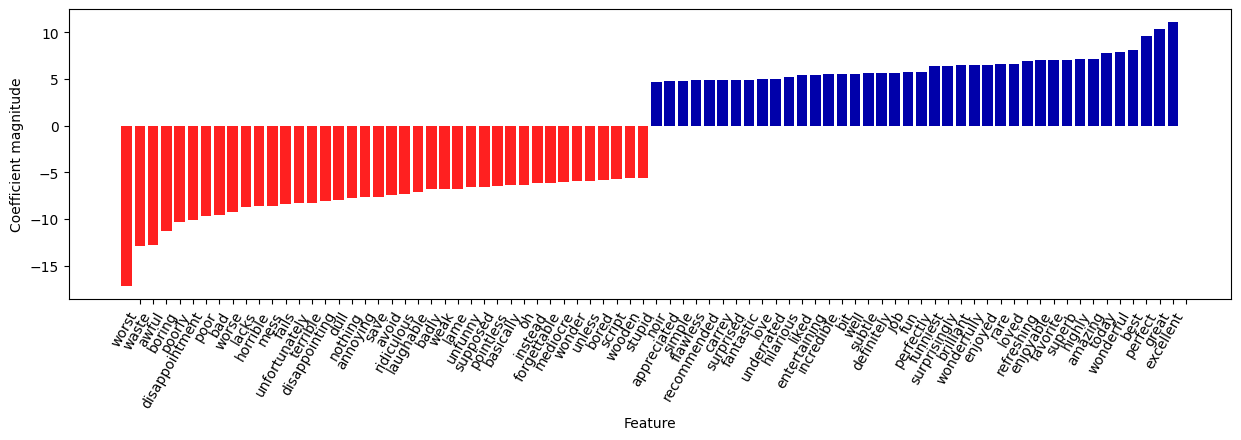

In [24]:
# tf-idf 특성으로 훈련시킨 로지스틱 회귀의 최댓값, 최솟값 계수
# 막대 그래프는 로지스틱 회귀의 가장 큰 계수 40개와 가장 작은 계수 40개를 보여줌
# 막대의 크기는 계수의 크기임
import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_[0], feature_names, n_top_features=40)

- 왼쪽의 음수 계수는 모델에서 부정적인 리뷰를 의미하는 단어에 속하고, 오른쪽 양수 계수는 긍정적인 리뷰의 단어에 해당
- 대부분의 단어는 매우 직관적임
- "worst", "disappointment", "laughable"는 부정적인 리뷰이며, 반면에 "excellent", "wonderful", "enjoyable", "refreshing"는 긍정적인 리뷰임을 말해줌
- "bit", "job", "today" 같은 단어들은 조금 덜 명확하지만 아마도 "good job"이나 "best today" 같은 구절의 일부로 보임

# 7. 여러 단어로 만든 BOW(n-그램)
- BOW 표현 방식은 단어의 순서가 완전히 무시된다는 큰 단점이 있음
- 그렇기 때문에 의미가 완전히 반대인 두 문자열 "it's bad, not good at all"과 "it's good, not bad at all"이 완전히 동일하게 변환됨
- 단어 앞에 등장하는 "not"은 (극단적일 경우) 문맥의 중요성을 잘 보여주는 예임
- 다행히도 BOW 표현 방식을 사용할 때 문맥을 고려하는 방식임
- 토큰 두 개를 바이그램(Bigram), 세 개를 트라이그램(Trigram)이라고 하며 일반적으로 연속된 토큰을 n-그램(n-gram)이라고 함
- CountVectorizer와 TfidfVectorizer는 ngram_range 매개변수에 특성으로 고려할 토큰의 범위를 지정할 수 있음
- ngram_range 매개변수의 입력값은 튜플이며 연속된 토큰의 최소 길이와 최대 길이임
- 다음은 앞에서 사용한 샘플 데이터임

In [25]:
print("bards_words:\n", bards_words)

bards_words:
 ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


- 기본 값은 최소 길이가 1이고 최대 길이가 1인 토큰마다 하나의 특성을 만듦
- 다시 말하면 정확히 토큰 하나임 (토큰 하나를 유니그램(Unigram)이라고 함)

In [26]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 13
어휘 사전:
 ['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'knows' 'man' 'the' 'think'
 'to' 'wise']


In [27]:
# 토큰 두 개가 연속된 바이그램만 만들려면 ngram_range에 (2, 2)를 지정
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 14
어휘 사전:
 ['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'knows himself' 'man knows' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


- 연속된 토큰의 수가 커지면 보통 특성이 더 구체적이고 많이 만들어짐
- bard_words에 있는 두 문장 사이에는 공통된 바이그램이 없음

In [28]:
print("변환된 데이터 (밀집 배열):\n", cv.transform(bards_words).toarray())

변환된 데이터 (밀집 배열):
 [[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


- 단어 하나가 큰 의미를 가진 경우가 많으므로 대부분의 애플리케이션에서 토큰이 최소 길이는 1임
- 많은 경우에 바이그램을 추가하면 도움이 됨
- 더 길게 5-그램까지는 도움이 되지만 특성의 개수가 매우 많아지며 구체적인 특성이 많아지기 때문에 과대적합될 가능성이 있음
- 이론상 바이그램의 수는 유니그램 수의 제곱이 되고, 트라이그램의 수는 유니그램의 세제곱이 되므로 특성의 개수가 많이 늘어남
- (영어) 언어의 구조상 실제로 테이터에 나타나는 높은 n-그램의 횟수가 많기는 하지만 이보다는 훨씬 적음

In [29]:
# 다음은 bards_words에 유니그램, 바이그램, 트라이그램을 적용한 예
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 39
어휘 사전:
 ['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise'
 'knows' 'knows himself' 'knows himself to' 'man' 'man knows'
 'man knows himself' 'the' 'the fool' 'the fool doth' 'the wise'
 'the wise man' 'think' 'think he' 'think he is' 'to' 'to be' 'to be fool'
 'wise' 'wise man' 'wise man knows']


- IMDb 영화 리뷰 데이터에 TfidfVectorizer를 적용하고 그리드 서치로 최적의 n-그램 범위를 찾아봄

In [30]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# 매개변수 조합이 많고 트라이그램이 포함되어 있기 때문에
# 그리드 서치 실행에 시간이 오래 걸림
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100], "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수:\n", grid.best_params_)

최상의 교차 검증 점수: 0.91
최적의 매개변수:
 {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


- 결과에서 보듯이 바이그램과 트라이그램을 추가해서 1% 이상 성능을 높였음
- ngram_range와 C 매개변수에 대한 교차 검증 정확도를 히트맵으로 나타냄

TypeError: Only length-1 arrays can be converted to Python scalars

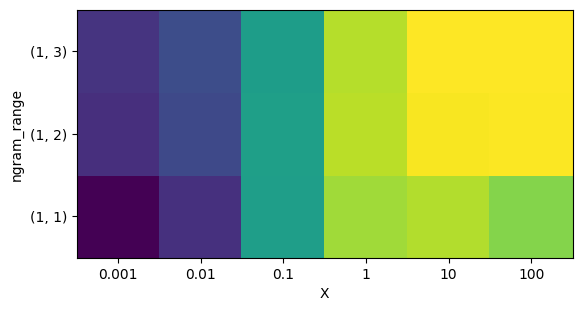

In [31]:
# 그리드 서치에서 테스트 점수를 추출
# 매개변수 ngram_range와 C에 대한 평균 교차 검증 정확도의 히트맵
import matplotlib.pyplot as plt

scores = grid.cv_results_["mean_test_score"].reshape(-1, 3).T
# 히트맵을 그림
heatmap = mglearn.tools.heatmap(scores, xlabel="X", ylabel="ngram_range", cmap="viridis", fmt="%.3f", xticklabels=param_grid["logisticregression__C"], yticklabels=param_grid["tfidfvectorizer__ngram_range"])
plt.colorbar(heatmap)

- 히트맵을 보니 바이그램이 성능을 크게 높여주며 트라이그램은 정확도 측면세어 성능이 조금만 향상되었음
- 모델이 어떻게 향상됐는지 더 잘 이해하기 위해 유니그램, 바이그램, 트라이그램을 포함해 최적 모델의 중요 계수를 그래프로 나타냈음

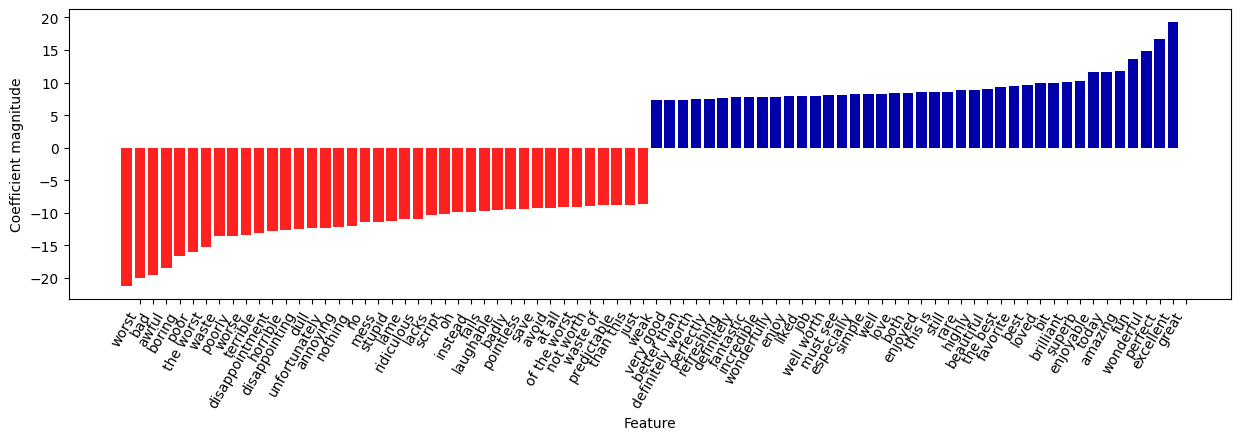

In [32]:
# 특성 이름과 계수를 추출
# tf-idf와 유니그램, 바이그램, 트라이그램을 사용한 모델에서 가장 중요한 특성
vect = grid.best_estimator_.named_steps["tfidfvectorizer"]
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps["logisticregression"].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

- 유니그램 모델에서는 없던 단어인 "worth"가 들어간 흥미로운 특성이 있음
- "not worth"는 부정적인 리뷰를 의미하지만 "definitely worth"와 "well worth"는 긍정적인 리뷰를 암시함
- 이는 문맥이 "worth" 단어의 의미에 영향을 주는 좋은 예
- 다음으로 왜 이런 특성들이 도움이 되었는지 알아보기 위해 트라이그램만 그래프로 나타내겠음
- 영향력이 큰 바이그램과 트라이그램의 대부분은 독립적일 땐 큰 의미가 없는 단어들로 구성되어 있음
- 예를 들어 "none of the", "the only good", "on and on", "this is one", "of the most" 등 임
- 그러나 유니그램의 중요도와 비교했을 때 상당히 제한적임

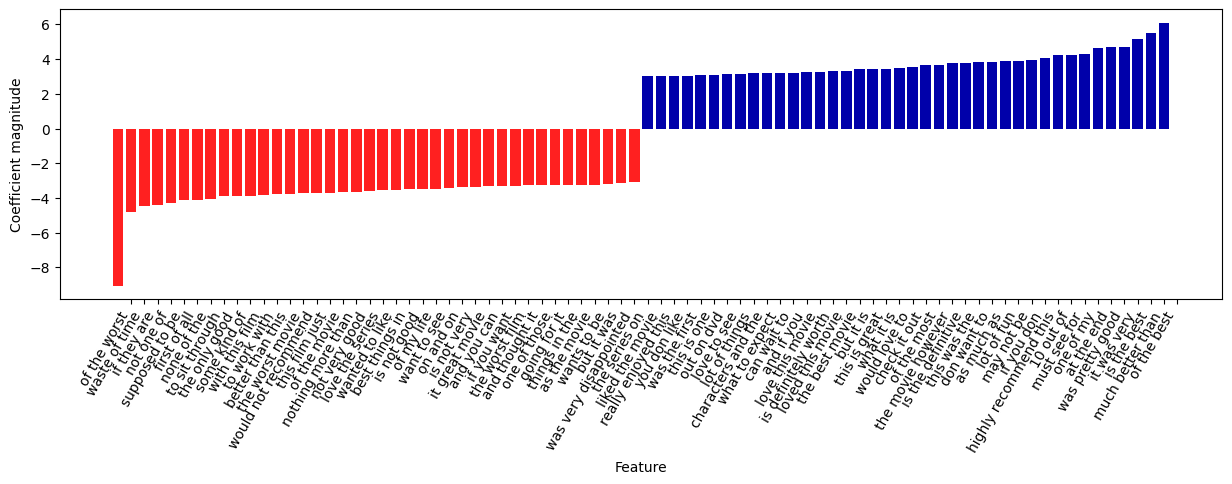

In [33]:
# 모델의 트라이그램 중요도를 나타낸 그래프
# 트라이그램 특성을 찾음
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# 트라이그램 특성만 그래프로 나타냄
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)

# 8. 고급 토큰화, 어간 추출, 표제어 추출
- 이전에 언급된 CountVectorizer와 TfidfVectorizer의 특성 추출은 비교적 단순
- 하지만 훨씬 더 정교한 방법도 있음
- 전문적인 텍스트 처리 애플리케이션이 뛰어난 부분은 BOW 모델의 첫 번째 단계인 토큰화
- 이 단계는 특성 추출을 위해 단어가 무엇으로 구성되었는지 정의
- 앞서 어휘 사전에 단수와 복수 단어가 함께 포함되어 있는 것을 보았음
- 예를 들어 "drawback"과 "drawbacks", "drawer"와 "drawers", "drawing"과 "drawings"임
- BOW 모델에서 "drawback"과 "drawbacks"의 의미는 매우 가까워서 이를 구분하면 과대적합되기 쉽고, 모델이 훈련 데이터를 완전하게 활용하지 못함
- 비슷하게 "replace", "replaced", "replacement", "replaces", "replacing" 같은 단어는 다른 동사 형태이거나 "to replace" 동사와 관련된 명사임
- 명사에 단수, 복수가 있는 것처럼 여러 동사형과 관련 단어들을 다른 토큰으로 다루면 모델을 일반화하는 데 도움이 되지 않음
- 이 문제를 해결하려면 각 단어를 그 단어의 어간(Stem)으로 표현해서 같은 어간을 가진 모든 단어를 구분해야 (또는 합쳐야)함
- 일일이 어미를 찾아 제외하는 규칙 기반 방식을 어간 추출(Stemming)이라고 함
- 대신 알려진 단어의 형태 사전(명시적이고 사람이 구축한 시스템)을 사용하고 문장에서 단어의 역할을 고려하는 처리 방식을 표제어 추출(Lemmatization)이라고 하며 단어의 표준 형태를 표제어라고 함
- 두 처리 방식, 즉 표제어 추출과 어간 추출은 단어의 일반형태를 추출하는 정규화(Nomalization)의 한 형태로 볼 수 있음
- 정규화의 또 다른 재미있는 사례는 맞춤법 교정으로, 실제로 도움이 되지만 이 책의 범위는 아님
- 정규화를 더 잘 이해하기 위해 널리 사용하는 포터(Poter) 어간 추출기(nltk 패키지에서 임포트)와 spacy 패키지에 구현된 표제어 추출 방식을 비교

In [34]:
# 라이브러리 버전 확인
import spacy
import nltk

print("spacy 버전", spacy.__version__)
print("nltk 버전", nltk.__version__)

spacy 버전 3.7.2
nltk 버전 3.8.1


In [35]:
# spacy의 영어 모델을 로드
en_nlp = spacy.load("en_core_web_sm")
# nltk의 PorterStemmer 객체를 만듦
stemmer = nltk.stem.PorterStemmer()

# spacy의 표제어 추출과 nltk의 어간 추출을 비교하는 함수
def compare_normalization(doc):
  # spacy로 문서를 토큰화
  doc_spacy = en_nlp(doc)
  # spacy로 찾은 표제어를 출력
  print("표제어:")
  print([token.lemma_ for token in doc_spacy])
  # PorterStemmer로 찾은 토큰을 출력
  print("어간:")
  print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [36]:
# 한 문장에 대해 표제어 추출과 Porter 어간 추출기의 차이를 비교
compare_normalization(u"Our meeting today was worse than yesterday, I'm scared of meeting the clients tomorrow.")

표제어:
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
어간:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


- 어간 추출이 항상 단어에서 어간만 남겨놓고 제거하므로 "was는 "wa"가 되지만, 표제어 추출은 올바른 동사형인 "be"를 추출
- 비슷하게 표제어 추출은 "worse"를 "bad"로 정규화시키는 반면 어간 추출은 "wors"가 되었음
- 어간 추출이 두 번째의 "meeting"을 "meet"로 바꾼 것이 또 다른 큰 차이
- 표제어 추출은 첫 번째 "meeting"은 명사로 인식해 그대로 두고 두 번째 나타났을 땐 동사로 인식해 "meet"로 바꿨음
- 일반적으로 표제어 추출은 어간 추출보다 훨씬 복잡한 처리를 거침
- 하지만 머신러닝을 위해 토큰 정규화를 할 때는 어간 추출보다 좋은 결과를 낸다고 알려져 있음
- scikit-learn에 두 정규화 방법이 구현되어 있지 않지만, CountVectorizer에서 tokenizer 매개변수를 사용하여 문서를 토큰화하는 방법을 따로 지정할 수 있음
- spacy 표제어 추출을 사용해서 문자열을 표제어 리스트로 변환하는 익명함수를 만듦

In [37]:
# 요구사항: spacy에서 표제어 추출 기능과 CountVectorizer의 토큰 분할기를 사용

# spacy의 언어 모델을 로드
en_nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# spacy 문서 처리 파이프라인을 사용해 자작 토큰 분할기를 만듦
# (우리만의 토큰 분할기를 사용)
def custom_tokenizer(document):
  doc_spacy = en_nlp(document)
  return [token.lemma_ for token in doc_spacy]

# 자작 토큰 분할기를 사용해 CountVectorizer 객체를 만듦
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

# 표제어 추출이 가능한 CountVectorizer 객체로 text_train을 변환
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape:", X_train_lemma.shape)

# 비교를 위해 표준 CountVectorizer를 사용
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape:", X_train.shape)

c:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_lemma.shape: (25000, 21880)
X_train.shape: (25000, 27271)


- 출력 결과에서 알 수 잇듯이, 표제어 추출은 특성 개수를 (표준 CountVectorizer에서 얻은) 27,271개에서 21,880개로 줄여줌
- 표제어 추출은 일부 특성들이 합치기 때문에 일종의 규제로 볼 수 있음
- 그래서 데이터셋이 작을 때도 표제어 추출이 성능을 높여줄 수 있음
- 표제어가 어떻게 효과가 있는지 보기 위해 StratifiedShuffleSplit을 사용해 훈련 세트의 1%만 훈련 폴드로 하고, 나머지는 테스트 폴드로 하여 교차 검증을 수행

In [38]:
# 훈련 세트의 1%만 사용해서 그리드 서치를 만듦
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {"C": [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=cv, n_jobs=-1)

# 기본 CountVectorizer로 그리드 서치를 수행
grid.fit(X_train, y_train)
print("최상의 교차 검증 점수 (기본 CountVectorizer): {:.3f}".format(grid.best_score_))

# 표제어를 사용해서 그리드 서치를 수행
grid.fit(X_train_lemma,y_train)
print("최상의 교차 검증 점수 (표제어): {:.3f}".format(grid.best_score_))

최상의 교차 검증 점수 (기본 CountVectorizer): 0.719
최상의 교차 검증 점수 (표제어): 0.719


- 여기서는 표제어 추출의 성능이 조금 더 높음
- 다른 특성 추출 기법들과 마찬가지로 데이터셋에 따라 결과에 차이가 있음
- 표제어 추출과 어간 추출은 모델을 더 낫게 (또는 적어도 더 간단하게) 만들어주기 때문에, 어떤 작업에서 마지막 성능까지 쥐어 짜내야 할 때 시도해보면 좋음

## 8-1. KoNLPy를 사용한 영화 리뷰 분석
- 이 책의 감성 분석 예제는 영어로 쓰인 영화 리뷰 데이터를 사용
- 한글의 경우 KoNLPy(코엔엘파이)와 CountVectorizer를 함께 사용하여 감성 분석을 할 수 있음
- 여기서 사용할 데이터셋은 한글로 된 영화 리뷰를 모은 (Naver sentiment movie corpus v1.0) (https://github.com/e9t/nsmc/)을 사용
- 이 말뭉치는 네이버 영화 사이트의 리뷰 20만 개를 묶은 데이터
- KoNLPy는 여러 언어로 만들어진 형태소 분석기를 파이썬에서 손쉽게 사용할 수 있도록 도와주는 도구
- KoNLPy를 설치하려면 파이썬 패키지 konlpy와 JPypel, 파이썬 3일 경우에는 JPypel-py3를 설치해야 함
- 플랫폼별 자세한 설치 방법은 KoNLPy의 설치 페이지(http://knlpy.org/ko/latest/install)을 참고
- KoNLPy는 5개의 형태소 분석기를 각각 하나의 태그 클래스로 지원
- 먼저 트위터에서 만든 한국어 처리기 open-korean-text(https://github.com/open-korean-text/open-korean-text)를 사용
- 네이버 영화 리뷰 데이터셋 깃허브에서 ratings_train.text와 ratings_test.txt를 내려받음
- 역자 깃허브의 data 폴더에도 이 두 파일이 포함되어 있음
- 이 데이터의 첫 줄은 제목이고 그 다음부터 한 줄에 리뷰 데이터가 하나씩 기록되어 있음
- 데이터를 읽어 들이기 위해 pandas를 사용
- 데이터 항목은 세 개이고 탭으로 구분되어 있으므로 read_csv 메서드를 사용할 때 구분자를 탭으로 지정
- 데이터에 빈 문자열이 있어도 nan으로 저장되지 않도록 keep_default_na=False로 지정하여 빈 문자열 그대로 저장되게 함

In [ ]:
import pandas as pd

df_train = pd.read_csv("data/ratings_train.txt", delimiter="\t", keep_default_na=False)
df_train.head(n=3)

- 우리가 사용할 데이터는 "document"열과 "label"열
- 레이블이 0이면 부정적인 리뷰고 1이면 긍정적인 리뷰
- 이제 pandas의 데이터프레임을 NumPy 배열로 바꿈

In [ ]:
text_train, y_train = df_train["document"].values, df_train["label"].values

In [ ]:
# 훈련 데이터와 마찬가지로 테스트 데이터도 데이터프레임으로 읽은 후 NumPy 배열로 변환
df_test = pd.read_csv("data/ratings_test.txt", delimiter="\t", keep_default_na=False)
text_test = df_test["document"].values
y_test = df_test["label"].values

- 훈련 데이터와 테스트 데이터의 크기와 클래스 비율을 확인
- 앞서 사용한 IMDb 데이터셋과 비슷하게 양성과 음성 데이터의 수가 비슷

In [ ]:
len(text_train), np.bincount(y_train)

In [ ]:
len(text_test), np.bincount(y_test)

- Okt 클래스 객체를 TfidfVectorizer와 함께 그리드 서치에 사용하려면 직렬화할 수 있도록 __setstate__, __getstate__ 메서드를 추가해야 함
- 다음과 같이 간단히 두 메서드를 추가한 PicklableOkt 클래스를 만듦
- 그 다음 PicklableOkt의 객체 okt를 생성

In [ ]:
from konlpy.tag import Okt

class PicklableOkt(Okt):
  def __init__(self, *args):
    self.args = args
    Okt.__init__(self, *args)
  
  def __setstate__(self, state):
    self.__init__(*state["args"])

  def __getstate__(self):
    return {"args": self.args}

okt = PicklableOkt()

- TfidfVectorizer의 min_df와 ngram_range, LogisticRegression의 규제 매개변수 C에 대해 그리드 서치를 적용
- make_pipeline을 사용하여 파이프라인 객체를 만들 때 TfidfVectorizer에 tokenizer 매개변수에 Okt 클래스의 형태소 분석 메서드인 morphs를 지정
- 수행시간이 오래 걸리기 때문에 여기에서는 훈련 데이터 중 1,000개의 샘플만 사용

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {"tfidfvectorizer__min_df": [3, 5, 7], "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)], "logisticregression__C": [0.1, 1, 10]}
pipe = make_pipeline(TfidfVectorizer(tokenizer=okt.morphs), LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)

# 그리드 서치를 수행
grid.fit(text_train[:1000], y_train[:1000])
print("최상의 교차 검증 점수: {:.3f}".format(grid.best_score_))
print("최적의 교차 검증 매개변수: ", grid.best_params_)

- 데이터를 1,000개만 사용해도 70%가 넘는 교차 검증 점수를 얻었음
- 테스트 세트에 있는 샘플 1,000개에 대한 점수를 확인
- 테스트 세트를 적용할 때는 파이프라인의 tfidfvectorizer 단계에서 transform 메서드를 호출한 후 변환된 데이터를 이용해 logisticregression 단계의 score 함수를 호출

In [ ]:
tfidfvectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_test = tfidfvectorizer.transform(text_test[:1000])
logisticregression = grid.best_estimator_.named_steps["logisticregression"]
score = logisticregression.score(X_test, y_test[:1000])
print("테스트 세트 점수: {:.3f}".format(score))

- 이번에는 C++ 기반의 Mecab 태그 클래스를 사용
- Mecab을 사용하려면 konlpy를 설치한 후 추가적인 설치가 필요
- 다만, Mecab은 윈도우를 지원하지 않음
- 먼저 앞에서와 같이 Mecab 클래스를 감싼 PicklableMecab 클래스를 만듦

In [ ]:
from konlpy.tag import Mecab

class PicklableMecab(Mecab):
  def __init__(self, *args):
    self.args = args
    Mecab.__init__(self, *args)

  def __setstate__(self, state):
    self.__init__(*state["args"])

  def __getstate__(self):
    return {"args": self.args}

mecab = PicklableMecab()

In [ ]:
# 앞에서와 동일한 매개변수 조합으로 그리드 서치를 수행
pipe = make_pipeline(TfidfVectorizer(tokenizer=mecab.morphs), LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)

# 그리드 서치를 수행
grid.fit(text_train[:1000], y_train[:1000])
print("최상의 크로스 밸리데이션 점수: {:.3f}".format(grid.best_score_))
print("최적의 크로스 밸리데이션 파라미터: ", grid.best_params_)

In [ ]:
tfidfvectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_test = tfidfvectorizer.transform(text_test[:1000])
logisticregression = grid.best_estimator_.named_steps["logisticregression"]
score = logisticregression.score(X_test, y_test[:1000])

print("테스트 세트 점수: {:.3f}".format(score))

- Mecab을 사용해 학습한 모델은 75%에 가까움
- 여전히 1,000개의 샘플만 사용했음
- 시간과 컴퓨팅 자원이 충분하다면 전체 샘플을 사용해 모델을 훈련하여 훨씬 더 높은 정확도를 달성할 수 있음
- 여기에 사용된 주피터 노트북은 역자의 깃허브에 07.8.1-konlpy.ipynb 이름으로 업로드되어 있음
- <참고자료>
- http://konlpy.org/ko/
- https://www.lucypark.kr/slides/2015-pyconkr/#39
- https://github.com/e9t/nsmc/

# 9. 토픽 모델링과 문서 군집화
- 텍스트 데이터에 자주 적용하는 특별한 기법으로 토픽 모델링(Topic Modeling)이 있음
- 이 용어는 비지도 학습으로 문서를 하나 또는 그 이상의 토픽으로 할당하는 작업을 통칭함
- '정치', '스포츠', '금융' 등의 토픽으로 묶을 수 있는 뉴스데이터가 좋은 예
- 한 문서가 하나의 토픽에 할당되면 이는 3장에서 본 것과 같은 문서를 군집시키는 문제가 됨
- 문서가 둘 이상의 토픽을 가질 수 있다면 이는 3장에서 본 분해 방법과 관련이 있음
- 학습된 각 성분은 하나의 토픽에 해당하며 문서를 표현한 성분의 계수는 문서가 어떤 토픽에 얼마만큼 연관되어있는지를 말해줌
- 사람들이 토픽 모델링에 대해 이야기할 때 종종 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)이라고 하는 특정한 성분 분해 방법을 말함

## 9-1. LDA
- 직관적으로 생각하면 LDA 모델은 함께 자주 나타나는 단어의 그룹(토픽)을 찾는 것임
- 또 LDA는 각 문서에 토픽의 일부가 혼합되어 있다고 간주함
- 머신러닝에서 토픽은 우리가 일상 대화에서 말하는 '주제'가 아니고, 의미가 있든 없든 PCA나 NMF로 추출한 성분에 가까운 것
- LDA의 토픽에 의미가 있다고 하더라도, 이것은 우리가 주제라고 부르는 그것은 아님
- 뉴스 기사의 예로 돌아가서, 두 명의 기자가 쓴 스포츠, 정치, 금융에 관한 기사가 있다고 가정
- 정치 기사에서는 "주지사", "선거", "정당" 등의 단어를 예상할 수 있는 반면, 스포츠 기사에서는 "팀", "점수", "시즌" 같은 단어가 예상됨
- 이런 그룹들의 단어는 함께 나타나는 경우가 많으며, 반대로 "팀"과 "주지사"는 함께 나타나는 경우가 드뭄
- 그러나 동시에 나타날 것 같은 단어의 그룹만 있는 것은 아님
- 두 기자는 다른 문장이나 다른 종류의 단어를 좋아할 수 있음
- 한 명은 "구별"이란 단어를 즐겨 쓰고 다른 한 명은 "분리"란 말을 좋아할 수 있음
- 이때 토픽은 A 기자가 즐겨 쓰는 단어와 B 기자가 즐겨 쓰는 단어가 될 수 있음
- 이 토픽은 일반적인 주제와는 관련이 없음
- 실제로 LDA가 어떻게 작동하는지 보기 위해 영화 리뷰 데이터셋에 적용
- 텍스트 문서에 대한 비지도 학습 모델에서 분석의 결과가 왜곡되지 않으려면 자주 나타나는 단어를 제거하는 것이 좋음
- 적어도 15%의 문서에서 나타나는 단어를 삭제한 후 가장 많이 등장하는 단어 10,000개에 대해 BOW 모델을 만듦

In [39]:
vect = CountVectorizer(max_features=10000, max_df=0.15)
X = vect.fit_transform(text_train)

- 한눈에 보기 쉽게 10개의 토픽으로 토픽 모델을 학습
- NMF의 성분과 비슷하게 토픽은 어떤 순서를 가지고 있지 않으며, 토픽의 수를 바꾸면 모든 토픽이 바뀌게 됨
- 기본 학습 방법("online") 대신 조금 느리지만 성능이 더 나은 "batch" 방법을 사용하고 모델 성능을 위해 "max_iter" 값을 증가시킴

In [40]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0, n_jobs=-1)

# 모델 생성과 변환을 한 번에 함
# 변환 시간이 좀 걸리므로 시간을 절약하기 위해 동시에 처리
document_topics = lda.fit_transform(X)

- LatentDirichletAllocation에는 토픽마다 각 단어의 중요도를 저장한 components_ 속성이 있음
- components_의 크기는 (n_topics, n_words)임

In [41]:
print("lda.components_.shape:", lda.components_.shape)

lda.components_.shape: (10, 10000)


- 각 토픽이 의미하는 것이 무엇인지 이해하기 위해 토픽에서 가장 중요한 단어를 확인
- print_topics는 특성들을 정돈하여 출력해주는 함수

In [42]:
# 토픽마다(components_의 행) 특성을 오름차순으로 정렬
# 내림차순이 되도록 [:, ::-1] 사용해 행의 정렬을 반대로 바꿈
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# CountVectorizer 객체에서 특성 이름을 구함
feature_names = np.array(vect.get_feature_names_out())

In [43]:
# 10개의 토픽을 출력
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         guy           series        saw           
family        us            comedy        episode       am            
real          american      worst         tv            thought       
beautiful     our           thing         episodes      watched       
both          documentary   re            shows         got           
us            history       stupid        season        book          
each          years         actually      new           now           
work          new           want          musical       10            
performance   human         nothing       years         read          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
acti

- 중요한 단어를 둘러보면, 토픽 1은 역사와 전쟁 영화에 대한 것으로 보이고, 토픽 2는 형편없는 코미디물이고, 토픽 3은 TV 시리즈에 관한 것 같음
- 토픽 4는 매우 일반적인 단어를 고른 것 같은 반면, 토픽 6은 어린이 영화로 보이고, 토픽 8은 영화제와 관련한 리뷰인 것으로 보임
- 10개의 토픽만 보면 각 토픽은 매우 폭넓은 주제를 다루고 있고, 그래서 데이터셋에 있는 여러 다른 종류의 리뷰를 포함
- 다음은 100개의 토픽으로 새로운 모델을 학습
- 많은 토픽을 사용하면 분석은 더 어려워지지만 데이터에서 특이한 부분을 잘 잡아낼 수 있음

In [44]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch", max_iter=25, random_state=0, n_jobs=-1)
document_topics100 = lda100.fit_transform(X)

In [45]:
# 100개의 토픽을 모두 나열하면 너무 길어지므로 재미있는 대표 토픽 몇 가지만 보겠음
topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::1]
feature_names = np.array(vect.get_feature_names_out())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
00            00            00            00            00            
owns          ounce         olivia        objects       packed        
oz            otto          oliver        objective     packs         
pace          othello       olds          object        pad           
paced         ostensibly    ol            nyc           padded        
pacific       ossessione    okay          ny            padding       
pacino        oscar         ok            nutty         page          
owning        orson         oil           nut           package       
pack          orphanage     oh            nuns          pages         
packed        orphan        ogre          nun           painful       
packs         orleans       offs          numerous      painfully     
pad           orlando       officials     numbingly     pains         
padded

- 이번에 추출한 토픽이 더 구체적으로 보이지만, 해석하기는 더 어려움
- 토픽 7은 공포 영화와 스릴러에 관한 것으로 보이며, 토픽 16과 54는 부정적인 리뷰를 고른 것 같고, 반면 토픽 63은 코미디에 긍정적인 리뷰를 잡나낸 것으로 보임
- 토픽을 이용해 추론을 더 잘 하려면 토픽에 할당된 문서를 보고 가장 높은 순위에 있는 단어의 의미를 확인해야 함
- 예를 들어, 토픽 45는 음악에 관한 것으로 보임
- 이 토픽에 할당된 리뷰를 확인

In [46]:
# 음악적인 토픽 45를 가중치로 정렬
music = np.argsort(document_topics100[:, 45])[::-1]
# 이 토픽이 가장 비중이 큰 문서 다섯개를 출력
for i in music[:10]:
  # 첫 두 문장을 출력
  print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'Delightful film directed by some of the best directors in the industry today. The film is also casting some of the great actors of our time, not just from France but from everywhere.\n'
b'Fairly funny Jim Carrey vehicle that has him as a News reporter who temporarily gets the power of God and wrecks havoc. Carrey is back in familiar ground here and looks to be having a good time, and Jennifer Aniston as his put upon girlfriend is also charming and affecting.\n'
b'Busy Phillips put in one hell of a performance, both comedic and dramatic. Erika Christensen was good but Busy stole the show.\n'
b"`Bruce Almighty' will sweep the Academy Awards with a record 14 Oscar wins! It will surpass `Titanic' as the highest grossing film of all time! Jim Carrey's illustriousness will be at such a supreme level that he will announce his presidential candidacy for the 2004 White House playoffs. Almighty then! These grandeur fantasies would only transpire if the filmmakers (Carrey included) would posses

- 여기서 볼 수 있듯이, 뮤지컬에서부터 일대기를 다룬 영화, 그리고 마지막 리뷰처럼 장르를 확인하기 어려운 영화까지 이 토픽은 여러 가지 음악 중심의 리뷰를 다루고 있음
- 토픽을 조사하는 다른 방법은 각 토픽의 가중치가 얼마인지 모든 리뷰에 걸쳐 document_topics 값을 합해서 보는 것임
- 각 토픽을 대표하는 두 단어로 토픽 이름을 붙였음

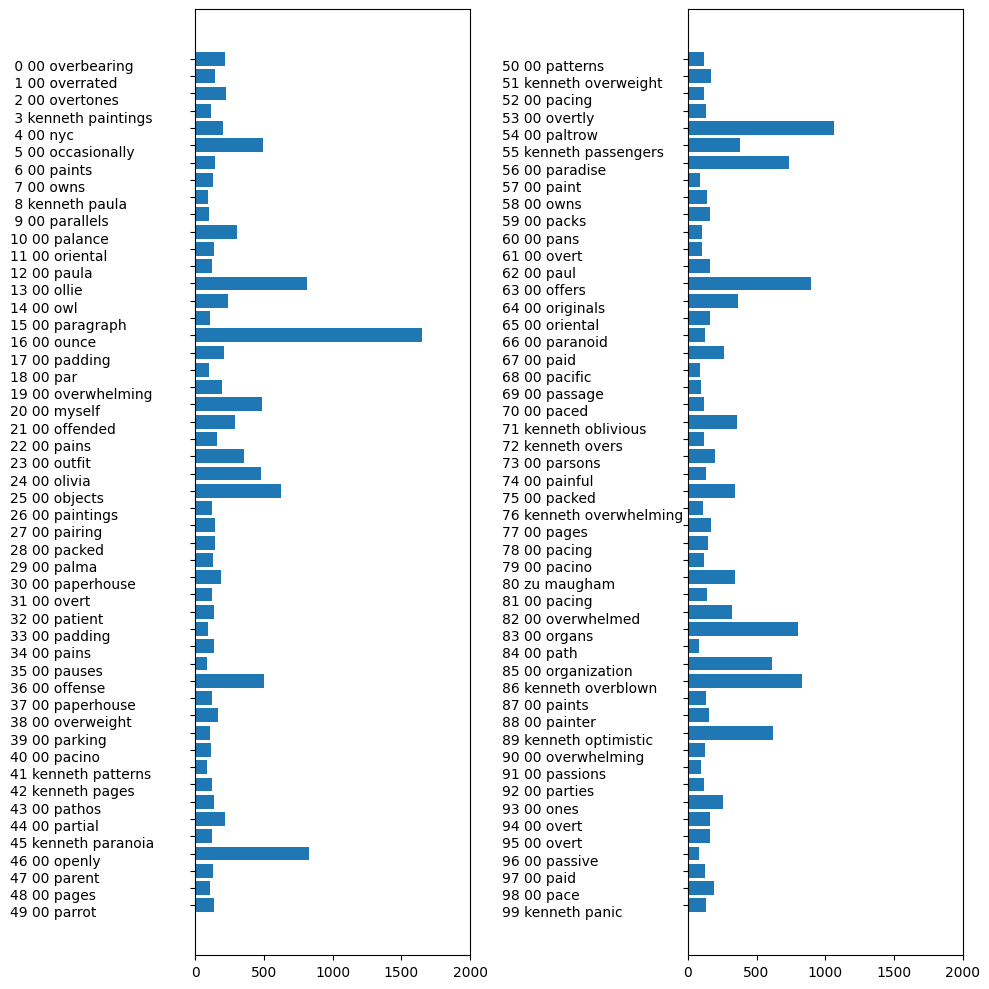

In [53]:
# LDA로 학습한 토픽 가중치
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# 열이 두 개인 막대 그래프
for col in [0, 1]:
  start = col * 50
  end = (col + 1) * 50
  ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
  ax[col].set_yticks(np.arange(50))
  ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
  ax[col].invert_yaxis()
  ax[col].set_xlim(0, 2000)
  yax = ax[col].get_yaxis()
  yax.set_tick_params(pad=130)
plt.tight_layout()

- 중요도가 높은 토픽 중 97번은 거의 불용어에 가깝고 약간 부정적 경향의 단어임
- 토픽 16은 확실히 부정적이고, 그 다음에 장르에 관련된 토픽들이 이어지고 36번과 37번은 칭찬하는 단어를 포함
- LDA가 장르와 점수라는 두 종류의 큰 토픽과 어디에도 속하지 않는 토픽 몇 개를 더 찾은 것 같음
- 대부분의 리뷰가 특정 영화에 대한 의견이거나 평가 점수를 합리화하거나 강조하기 위한 댓글이라는 사실은 재미있는 발견
- LDA와 같은 토픽 모델은 레이블이 없거나, 여기서처럼 레이블이 있더라도 큰 규모의 텍스트 말뭉치를 해석하는 데 좋은 방법임
- LDA는 확률적 알고리즘이기 때문에 random_state 매개변수를 바꾸면 결과가 많이 달라짐
- 토픽으로 구별하는 게 도움이 되더라도 비지도 학습에서 내린 결론은 보수적으로 평가해야 하므로 각 토픽에 해당하는 문서를 직접 보고 직관을 검증하는 게 좋음
- LDA.transform 메서드에서 만든 토픽이 지도 학습을 위한 압축된 표현으로 사용될 수도 있음
- 특별히 훈련 샘플이 적을 때 유용

# 10. 요약 및 정리
- 자연어 처리(NLP)의 한 예로 영화 리뷰를 분류하는 애플리케이션을 사용해 텍스트 처리의 기초적인 내용을 다뤘음
- 텍스트 데이터를 처리할 때 여기서 소개한 방법들이 좋은 시작점이 될 것
- 특히 스팸이나 부정거래 탐지, 감성 분석 같은 텍스트 분류 작업에서 BOW 표현은 간단하고 강력한 해법
- 머신러닝의 많은 경우가 그렇듯이 데이터의 표현이 자연어 처리 애플리케이션의 핵심이고 추출된 토큰과 n-그램을 분석하면 모델링 과정에서 필요한 많은 통찰을 얻게 됨
- 텍스트 처리 애플리케이션에서는 지도 학습이나 비지도 학습 작업을 위해 이번 장에서 본 것처럼 모델을 자체적으로 분석해 의미를 찾을 수 있을 때가 많음
- 실전에서 자연어 처리 기반의 방법을 사용할 때 이 장점을 최대한 활용해야 함
- 자연어와 텍스트 처리는 넓은 연구 분야이고 이 책에서 고수준의 기법을 자세히 다루기는 어려움
- 앞서 본 CountVectorizer와 TfidfVectorizer에는 비교적 간단한 텍스트 처리 방법만 구현되어 있음
- 더 고수준의 텍스트 처리를 하려면 spacy(비교적 최근에 나왔고 효율적이며 잘 설계된 패키지임), nltk(매우 잘 구축되어 있고 기능이 풍부하지만 조금 오래된 라이브러리임), gensim(토픽 모델링이 강점인 자연어 처리 패키지임) 파이썬 패키지를 추천
- 이 책에서 다룰 내용은 아니지만, 최근에 신경망과 관련된 몇 가지 연구가 텍스트 처리 분야에서 매우 두각을 보이고 있음
- 하나는 word2vec 라이브러리에 구현된 단어 벡터(Word Vector) 또는 분산 단어 표현(Distributed Word Representation)이라는 연속적인 벡터 표현
- 자연어 처리에서 최근에 가속이 붙어 빠르게 성장하는 또 하나의 분야는 텍스트 처리에 순환 신경망(Recurrent Neural Networks, RNN)을 적용하는 것
- RNN은 신경망의 한 종류로, 클래스 레이블을 할당하는 분류 모델과 달리 텍스트를 출력할 수 있음
- 텍스트 출력을 만들 수 있기 때문에 자동 번역이나 자동 요약에 RNN이 잘 들어맞음
- 텐서플로 프레임워크를 사용한 예제는 텐서플로 웹사이트(https://www.tensorflow.org/tutorials/seq2seq)에서 볼 수 있음